<!--COURSE_INFORMATION-->
*This notebook contains course material from [CBE 40455 Process Operations](http://jckantor.github.io/CBE40455/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/CBE40455).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Getting Started with CVXPY](01.01-Getting-Started-with-CVXPY.ipynb) | [Contents](index.ipynb) | [Getting Started with Gurobi](01.03-Getting-Started-with-Gurobi.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/01.02-Doing-More-with-CVXPY.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Doing More with CVXPY

This [Jupyter notebook](http://jupyter.org/notebook.html) demonstrates use of the [CVXPY](http://www.cvxpy.org/en/latest/) package for describing and solving convex optimization problems. CVXPY provides a modeling language embedded within Python that is well suited to linear and quadratic optimization problems with linear constraints. A limited set of solvers are distributed with CVXPY, and interfaces are available for others. Further documentation is available [here (.pdf)](https://media.readthedocs.org/pdf/cvxpy/latest/cvxpy.pdf).

## Installation

It is necessary to install CVXPY before use. Instructions can be found [here](http://www.cvxpy.org/en/latest/install/). If you happen to be using the Anaconda distribution of Python, the following cell should be sufficient for installation.

In [0]:
!conda install -c cvxgrp -y cvxpy

Fetching package metadata ...............
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /Users/jeff/anaconda:
#
cvxpy                     0.4.9                    py35_0    cvxgrp


## Solving linear equations

One of the simpliest use cases for cvxpy is solving a system of linear equations. For example, consider the pair of the equations

\begin{align*}
3\,x + 4\,y & = 26 \\
2\,x - 3\,y & = -11
\end{align*}

where $x$ and $y$ are the unknowns. Each equation is a linear equality constraint. The problem is easily solved with a few simple cvxpy constructss.

In [0]:
import numpy as np
import cvxpy as cvx

# create the variables to solve for
x = cvx.Variable()
y = cvx.Variable()

# create a list of equality constraints
eqns = [
    3*x + 4*y == 26,
    2*x - 3*y == -11
]

# create a problem instance 
prob = cvx.Problem(cvx.Minimize(0),eqns)

# solve
prob.solve()
print(prob.status)

# display solution
print(x.value)
print(y.value)

optimal
2.0
5.0


## Regression: Evidence of Climate Change

Get the historical record of ice out dates on Rainy Lake, Minnesota. Rainy Lake is a large lake, approximately 1000 sq. km., located on the Minnesota/Ontario border. Reliable records for ice-out date goes back to 1935, where for this lake ice-out is defined as the first day the lake can be navigated from one end to the other following a specified route.

The next cell downloads and extracts the historical ice-out date from Climatology office of the Minnesota Department of Natural Resources.

Data Download Status: OK


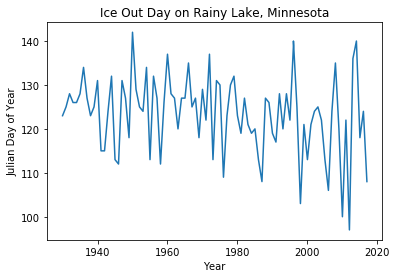

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from urllib.request import urlopen
import json
from dateutil.parser import parse
import datetime

# Lake ID for Rainy Lake
lakeid = '69069400'

# Get Ice-out Data
url = 'http://www.dnr.state.mn.us/services/climatology/ice_out_by_lake.html?id='+lakeid
response = urlopen(url).read().decode('utf8')
data = json.loads(response) 
print('Data Download Status: ' + data['status'])

# Calculate ice out 'day of year' for each date
dates = [parse(d['date']) for d in data['result']['values']]

year = np.array([d.year for d in dates])
iceout = np.array([1 + datetime.date.toordinal(d) - datetime.date(d.year,1,1).toordinal()
                for d in dates ])

plt.plot(year, iceout)
plt.title('Ice Out Day on Rainy Lake, Minnesota')
plt.ylabel('Julian Day of Year')
plt.xlabel('Year');

Create a regression model and fit using cvxpy.

In [0]:
# variables are slope, intercept, and predicted values

slope = cvx.Variable()
intercept = cvx.Variable()
pred = cvx.Variable(len(year))

con = [pred == (intercept + slope*(year-1930))]
obj = cvx.Minimize(cvx.norm(iceout-pred,2))

prob = cvx.Problem(obj,con)
prob.solve()

print("    Slope: {0:8.4f}".format(slope.value))
print("Intercept: {0:8.4f}".format(intercept.value))

NameError: name 'cvx' is not defined

Plot the resulting fit and compare to the original data.

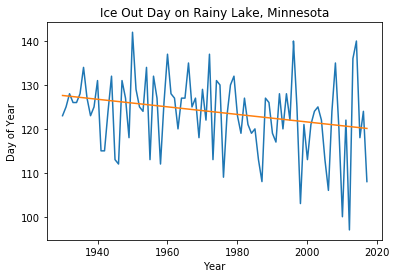

In [0]:
plt.plot(year, iceout, year, pred.value)
plt.title('Ice Out Day on Rainy Lake, Minnesota')
plt.ylabel('Day of Year')
plt.xlabel('Year');

## Integer Program

Let's consider the problem

\begin{align*}
\text{Minimize}\quad & 4 x + 6y \\
\text{subject to}\quad & 2x + 2y \geq 5 \\
& x - y \leq 1 \\
& x,y \geq 0 \\
& x,y \in \text{Integer}
\end{align*}

Let's first solve this problem ignoring the integer constraints on $x$ and $y$.  This is known as the 'relaxation' of an integer or binary programming problem.

In [0]:
import numpy as np
import cvxpy as cvx

# create the variables to solve for
x = cvx.Variable()
y = cvx.Variable()

# create a list of equality constraints
constraints = [
    2*x + 2*y >= 5,
    x - y <= 1,
    x >= 0,
    y >= 0
]

obj = cvx.Minimize(4*x + 6*y)

# create a problem instance 
prob = cvx.Problem(obj,constraints)

# solve
prob.solve()
print("status = ", prob.status)

# display solution
print("x = ", x.value)
print("y = ", y.value)
print("Obj = ", prob.value)

status =  optimal
x =  1.74999999184
y =  0.750000000732
Obj =  11.499999971753716


Since this is a minimization, the relaxed solution provides a lower bound on the solution of the integer problem. The next step is to define variables $x$ and $y$ as integer variables using `cvx.Int()` function.

In [0]:
import numpy as np
import cvxpy as cvx

# create the variables to solve for
x = cvx.Int()
y = cvx.Int()

# create a list of equality constraints
constraints = [
    2*x + 2*y >= 5,
    x - y <= 1,
    x >= 0,
    y >= 0
]

obj = cvx.Minimize(4*x + 6*y)

# create a problem instance 
prob = cvx.Problem(obj,constraints)

# solve
prob.solve()
print("status = ", prob.status)

# display solution
print("x = ", x.value)
print("y = ", y.value)
print("Obj = ", prob.value)

status =  optimal_inaccurate
x =  1.99999998886
y =  1.00000001165
Obj =  14.000000025301762


The solvers distributed with CVXPY tyically employ interior-point algorithms augmented with a branch and bound strategy for integer or boolean variables. A consequence is that integer solutions are reported as floating point numbers that may need rounding for some applications. 

In [0]:
print('Integer Solution x = ', int(round(x.value)))
print('Integer Solution y = ', int(round(y.value)))

Integer Solution x =  2
Integer Solution y =  1


<!--NAVIGATION-->
< [Getting Started with CVXPY](01.01-Getting-Started-with-CVXPY.ipynb) | [Contents](index.ipynb) | [Getting Started with Gurobi](01.03-Getting-Started-with-Gurobi.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/01.02-Doing-More-with-CVXPY.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
